<a href="https://colab.research.google.com/github/TivsLThree/CAP-4630-Artificial-Intelligence/blob/master/Homework/HW4/HW4V1_pretrained_convnet_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-16 22:44:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  49.3MB/s    in 1.3s    

2020-04-16 22:44:29 (49.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import Xception
# Change the conv_base
#conv_base = VGG16(
#    weights='imagenet', 
#    include_top=False, 
#    input_shape=(150, 150, 3))
#conv_base = ResNet50( # didn't like these results
#    include_top = False, 
#    weights = 'imagenet', 
#    input_shape=(150,150,3))
conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


83689472/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# Make small changes to classifier. Reduced dense layer size and added the drop out.
# I assume this dense layer reduction was way too much. May actually expand it
# For the next classifier, I am considering adding another dropout between the flatten and dense node.
# I may also add another dense layer with another activation to see if I get better results. 
# It seems like these changes may have made it worse. Must have reduced the dense layer too much. 
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,415,337
Trainable params: 6,553,857
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy',  # smaller learning rate
    optimizer=optimizers.RMSprop(lr=1e-6), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 304ms/step - loss: 0.6745 - acc: 0.5985 - val_loss: 0.3186 - val_acc: 0.8650
Epoch 2/30
100/100 [==============================] - 21s 206ms/step - loss: 0.5830 - acc: 0.7015 - val_loss: 0.2392 - val_acc: 0.9210
Epoch 3/30
100/100 [==============================] - 21s 205ms/step - loss: 0.5285 - acc: 0.7415 - val_loss: 0.1441 - val_acc: 0.9370
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4987 - acc: 0.7635 - val_loss: 0.1993 - val_acc: 0.9500
Epoch 5/30
100/100 [==============================] - 21s 208ms/step - loss: 0.4709 - acc: 0.7915 - val_loss: 0.0460 - val_acc: 0.9580
Epoch 6/30
100/100 [==============================] - 20s 204ms/step - loss: 0.4419 - acc: 0.7945 - val_loss: 0.2557 - val_acc: 0.9540
Epoch 7/30
100/100 [==============================] - 20s 205ms/step - loss: 0.4259 - acc: 0.8090 - val_lo

## Display curves of loss and accuracy during training

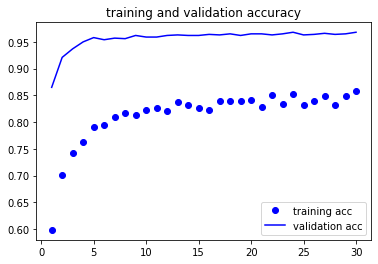

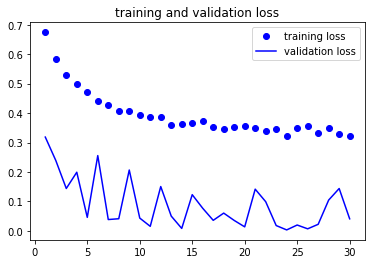

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True


for layer in conv_base.layers:
  if layer.name == 'block1_conv1' or layer.name == 'block1_conv2':
    layer.trainable = True;

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-6), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 38s 384ms/step - loss: 0.1773 - acc: 0.9295 - val_loss: 0.1987 - val_acc: 0.9480
Epoch 2/100
100/100 [==============================] - 27s 267ms/step - loss: 0.1952 - acc: 0.9205 - val_loss: 0.1031 - val_acc: 0.9540
Epoch 3/100
100/100 [==============================] - 27s 267ms/step - loss: 0.1676 - acc: 0.9240 - val_loss: 0.0901 - val_acc: 0.9490
Epoch 4/100
100/100 [==============================] - 27s 267ms/step - loss: 0.1737 - acc: 0.9295 - val_loss: 0.3367 - val_acc: 0.9520
Epoch 5/100
100/100 [==============================] - 27s 267ms/step - loss: 0.1639 - acc: 0.9310 - val_loss: 0.1036 - val_acc: 0.9540
Epoch 6/100
100/100 [==============================] - 27s 266ms/step - loss: 0.1803 - acc: 0.9190 - val_loss: 0.3249 - val_acc: 0.9500
Epoch 7/100
100/100 [==============================] - 27s 268ms/step - loss: 0.1742 - acc: 0.9340 - val_loss: 0.1496 - val_acc: 0.9480
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)